In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns

In [57]:
yelp = pd.read_json('./yelp_review_training_dataset.jsonl', lines=True)
yelp.head()

,review_id,text,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1


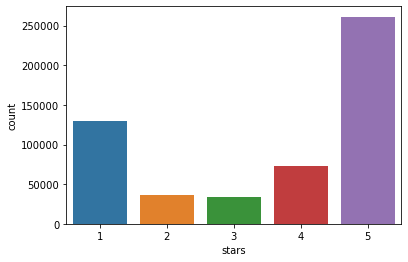

In [74]:
stars = yelp['stars'].values
ax = sns.countplot(x="stars",data=yelp)

In [4]:
yelp.shape

(533581, 3)

In [5]:
yelp[yelp.stars.notnull()]

,review_id,text,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1
...,...,...,...
533576,2vQO_kmSr6YPBrR8GH_FPA,Dr Young and her assistants take obvious pride...,5
533577,DUdLTGVpgsi0sv_g4A5ITQ,We started our 20 month of daughter here on an...,5
533578,AKGELpRNTTXajuZHbPxdJg,"First of all, they are supposed to open at 9:0...",2
533579,ghYZM7lqzjej05I_T3vYyA,It's not often that you visit a company and th...,5


In [6]:
x_train = yelp['text'].values

In [7]:
x_train[0]

'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.'

In [8]:
import re
symbol = r'\w+|[^\s\w]+'
res = re.findall( symbol, x_train[0])
res

['Total',
 'bill',
 'for',
 'this',
 'horrible',
 'service',
 '?',
 'Over',
 '$',
 '8Gs',
 '.',
 'These',
 'crooks',
 'actually',
 'had',
 'the',
 'nerve',
 'to',
 'charge',
 'us',
 '$',
 '69',
 'for',
 '3',
 'pills',
 '.',
 'I',
 'checked',
 'online',
 'the',
 'pills',
 'can',
 'be',
 'had',
 'for',
 '19',
 'cents',
 'EACH',
 '!',
 'Avoid',
 'Hospital',
 'ERs',
 'at',
 'all',
 'costs',
 '.']

In [9]:
training = [re.findall( symbol, i) for i in x_train]

In [28]:
import numpy as np
training = np.array(training)

<ipython-input-28-c84e4e09100d>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


In [30]:
np.random.shuffle(training)
training = list(training)
first_part = round(len(training) * 1)
second_part = round(len(training) * 0.2)
print(first_part)

533581


In [14]:
from gensim.models import Word2Vec
self_model = Word2Vec(training[:first_part], min_count=1)

/Users/jeffreyzhang/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [31]:
training_sample = [[self_model.wv.key_to_index[word] for word in sentence] for sentence in training[:second_part]]


In [32]:
self_model.wv.index_to_key[0]

'.'

In [77]:
from sklearn.model_selection import train_test_split
y = np.array(stars[:second_part])-1
training_sample = np.array(training_sample)
train_x, val_x, train_y, val_y = train_test_split(training_sample, y, test_size=0.3, random_state=42)

In [78]:
val_y

array([4, 4, 0, ..., 0, 4, 4])

In [79]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [80]:
maxlen = 200
train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=maxlen)
val_x = keras.preprocessing.sequence.pad_sequences(val_x, maxlen=maxlen)

In [81]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

vocab_size = 300000

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)



In [82]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_x, train_y, batch_size=32, epochs=2, validation_data=(val_x, val_y)
)

Epoch 1/2
2335/2335 [==============================] - 641s 274ms/step - loss: 1.3758 - accuracy: 0.4767 - val_loss: 1.3410 - val_accuracy: 0.4847
Epoch 2/2
2335/2335 [==============================] - 675s 289ms/step - loss: 1.3448 - accuracy: 0.4793 - val_loss: 1.3369 - val_accuracy: 0.4847


In [107]:
model.save_weights('./navie-model.h5')
self_model.save("word2vec.model")

(500, 3)


<ipython-input-111-1fe1ae6ae852>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)
<ipython-input-111-1fe1ae6ae852>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_sample = np.array(training_sample)


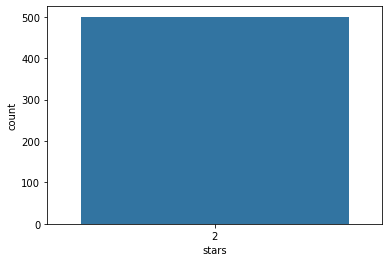

In [111]:
test = pd.read_json('./yelp_challenge_5_with_answers.jsonl', lines=True)
test.head()

def preprocessing(yelp, w_model, ratio=1, maxlen=200):
    yelp = yelp[yelp.stars.notnull()]
    stars = yelp['stars'].values
    ax = sns.countplot(x="stars",data=yelp)
    print(yelp.shape)
    symbol = r'\w+|[^\s\w]+'
    x_train = yelp['text'].values
    training = [re.findall(symbol, i) for i in x_train]
    training = np.array(training)
    np.random.shuffle(training)
    training = list(training)
    first_part = round(len(training) * ratio)
    word_model = w_model
    word_model.build_vocab(training, update=True)
    word_model.train(training, total_examples=word_model.corpus_count, epochs=word_model.epochs)
    training_sample = [[word_model.wv.key_to_index[word] for word in sentence] for sentence in training]
    y = np.array(stars[:first_part])
    training_sample = np.array(training_sample)
    x = keras.preprocessing.sequence.pad_sequences(training_sample, maxlen=maxlen)
    return x, y

x, y = preprocessing(test, self_model)

In [110]:
from sklearn import metrics,preprocessing,model_selection
from sklearn.metrics import accuracy_score
print(x)
pred = model.predict(x)
print(pred)
pred = np.argmax(pred, axis=1) + 1
print(pred)
print(metrics.classification_report(y, pred))

[[   0    0    0 ... 1001  143    0]
 [   0    0    0 ...  738   10   25]
 [ 452    3  155 ...   14 3349    0]
 ...
 [   0    0    0 ...   24   40    0]
 [4949  193    3 ...  116   24    0]
 [   0    0    0 ...    4 3113    0]]
[[0.24028295 0.0733828  0.07195764 0.14405185 0.47032475]
 [0.23955353 0.07027433 0.07138675 0.14383917 0.4749462 ]
 [0.24092089 0.06688959 0.06810812 0.14110763 0.48297375]
 ...
 [0.24014533 0.07609994 0.07410922 0.14559425 0.4640513 ]
 [0.24055946 0.06920134 0.06974408 0.14193065 0.47856447]
 [0.24387169 0.07734318 0.07060599 0.14177135 0.46640784]]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 